### About

In this notebook, I implement Faster-RCNN fine-tuning workflow with the following workflow:

* Install & import data
* Preprocess data to match input form 
* Configure FRCNN meta-arch and load weights
* Train on prediction heads 
* Unfreeze and train 
* Evaluation 

The dataset used in this notebook is `med_res_3.zip` and `comp1.zip`

This notebook is adapted from the SSD + MobileNetV2 notebook that I used last summer. Aside from overall clean-up, the following major changes were made:

* Image augmentation refactored into one `options` arguement 
* Dataset is split into train-val-test, with a pre-defined test set, and a dynamically growing train-val set (depending on which dataset is used) with 80-20 ratio
* Summary & outputs displayed in tables and outputed as csv


### Installs

- Install modules
- clone tensorflow.models
- download dataset from drive

**Install modules** ~ 1min

In [10]:
# Install modules
!pip install -q Cython contextlib2 pycocotools tf_slim
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

# Used for rotation
!pip install -q -U tensorflow-addons

**Clone tensorflow.models & install**

In [11]:
%%bash
cd /content
git clone --quiet https://github.com/tensorflow/models.git

cd /content/models/research
protoc object_detection/protos/*.proto --python_out=.

fatal: destination path 'models' already exists and is not an empty directory.


In [12]:
import os
os.environ['PYTHONPATH'] += ':/content/models:/content/models/research/:/content/models/research/slim/'
import sys
sys.path.append("/content/models")

!python models/research/object_detection/builders/model_builder_test.py

2021-02-13 22:04:00.318822: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [13]:
import matplotlib
import matplotlib.pyplot as plt

import os
import shutil
import json
import random
import re
import io
import imageio
import cv2
import glob
import scipy.misc
import math
import time

import numpy as np
import pandas as pd 
import tensorflow_addons as tfa
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm 
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

%cd /content/models/research
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder
%cd /content/

%matplotlib inline

/content/models/research
/content


**Download Data from drive**

```

Data
  - bboxes
  - images
  test_set.txt

```



In [14]:
# Download data from drive into cwd
if 'Data' not in os.listdir():
  !cp "/content/drive/MyDrive/waste_detection/Data/med_res_3.zip" .
  !unzip -q med_res_3.zip -d Data
  # Remove the zip file 
  !rm med_res_3.zip

In [15]:
if 'comp_data' not in os.listdir():
  !cp "/content/drive/MyDrive/waste_detection/Data/comp1.zip" .
  !unzip -q comp1.zip -d comp_data
  # Remove the zip file 
  !rm comp1.zip

In [16]:
if 'comp_data_2' not in os.listdir():
  !cp "/content/drive/MyDrive/waste_detection/Data/comp2.zip" .
  !unzip -q comp2.zip -d comp_data_2
  # Remove the zip file 
  !rm comp2.zip

In [17]:
# Move comp2 into comp (temporary block, refactor later please)

for filename in os.listdir('/content/comp_data_2/images/'):
  # print(filename)
  os.replace(os.path.join('/content/comp_data_2/images/', filename), os.path.join('/content/comp_data/images/', filename))

for filename in os.listdir('/content/comp_data_2/bboxes/'):
  # print(filename)
  os.replace(os.path.join('/content/comp_data_2/bboxes/', filename), os.path.join('/content/comp_data/bboxes/', filename))

**Helper functions** (for prep below)



In [18]:
# Splitting train-val/test data

# The original dataset is not split because we often change the number of classes
# that we are training, and we may want to change the test set depending on which 
# classes we are training. This is easier done with a txt file containing the test
# images and making the train-val/test folders online.

def split_data(IMG_DIR, TRAIN_VAL_DIR, TEST_DIR, valid_filenames, test_filenames):
  '''
  Splits images from source directory to train-val/test folders

  Args
  --------
  IMG_DIR  : path to directory containing images 
  TRAIN_VAL_DIR: target training/validation folder, should already exist
  TEST_DIR : target testing folder, should already exist
  valid_filenames: list of images in IMG_DIR that include classes that we want to train
  test_filenames: list of test image filenames
  '''
  # Get a list of image filenames from IMG_DIR
  img_files = []
  for filename in os.listdir(IMG_DIR):
      if filename.endswith('.jpg') and filename in valid_filenames:
          img_files.append(filename)

  # Split these images into either train set or test set
  training_set = []
  testing_set = []
  for filename in img_files:
    if filename in test_filenames:
      testing_set.append(filename)
    else:
      training_set.append(filename)

  # move the files
  for filename in training_set:
      os.replace(os.path.join(IMG_DIR, filename), os.path.join(TRAIN_VAL_DIR, filename))
  for filename in testing_set:
      os.replace(os.path.join(IMG_DIR, filename), os.path.join(TEST_DIR, filename))

In [19]:
# Loading image and annotation 

def _load_image_into_numpy_array(path):
  """
  Load an image from file into a numpy array.
  Used internally in image_to_np

  Args:
  ------------
    path: a file path.

  Returns:
  -----------
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  # tic = time.perf_counter()
  # img_data = tf.io.gfile.GFile(path, 'rb').read()
  # image = Image.open(BytesIO(img_data))
  # (im_width, im_height) = image.size
  # toc = time.perf_counter()

  # print(f'read image:{toc-tic}')

  # tic = time.perf_counter()
  # out = np.array(image.getdata()).reshape(
  #     (im_height, im_width, 3)).astype(np.uint8)
  # toc = time.perf_counter()
  # print(f'get output:{toc-tic}')

  return np.asarray(Image.open(path))

def image_to_np(filenames, image_dir, w, h):
  '''
  Loads all images in a directory, and returns a list of resized numpy arrays

  Args
  ----------
    filenames: list, list of paths 
    w:     int, target width 
    h:     int, target height
  
  Returns
  ----------
    output: list of numpy image arrays in (h, w, 3)

  '''
  # Initiates empty list object
  output = [None] * len(filenames)

  for i, filename in enumerate(tqdm(filenames)):
    # get numpy array of the image

    img = _load_image_into_numpy_array(os.path.join(image_dir, filename))

    # resize the image into target width and height
    res = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    output[i] = res
  return output

def extract(label, category):
  '''
  returns the value of a label dictionary only if an annotation exists for category
  '''
  if label[category] is not None:
    return np.array(label[category])

def json_to_np(filenames, label_dir, selected_classes):
  '''
  Converts json files into desired numpy arrays as annotations

  Args
  ----------
    filenames: list of valid json file paths
    label_dir: path to label directory where filenames will be found
    selected_classes: the classes which will be used in training

  Returns
  --------- 
    output_boxes: np.array, (N x 4)
    output_classes: np.array, (N x 1)
      each index indicates the index of the class

  '''
  output_boxes, output_classes = [], []

  for i, filename in enumerate(filenames):
      label_path = os.path.join(label_dir, filename)
      with open(label_path, 'r') as file:
        label = json.load(file)

      # filters label dictionary to only the selected classes
      categories = np.array([extract(label, selected_classes[i]) for i in selected_classes])

      # initiate boxes
      boxes = np.array([[0, 0, 0, 0]])
      classes = np.array([])

      for index, category in enumerate(categories):
        # Append all boxes & classes if they exist
        if category is not None:
          boxes = np.vstack([boxes, category])
          classes = np.append(classes, np.array([int(index+1)]*len(category)))
    
      output_boxes.append(boxes[1:].astype('float')) # first row is ignored
      output_classes.append(classes.astype('int32'))

  return output_boxes, output_classes

In [20]:
# Visualization function 

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold = 0.8):
  """
  Wrapper function to visualize detections.

  Args
  --------
    image_np: uint8 numpy array 
      (img_height, img_width, 3)
    boxes: np.array()
      (N, 4)
    classes:np.array()
      (N, number_of_classes)
    scores: np.array or None.  
      If scores=None, then this function assumes that the boxes to be plotted 
      are groundtruth boxes and plot all boxes as black with no classes or scores.
    category_index: {id: classname}
      a dict containing category dictionaries 
    figsize: size for the figure.
    image_name: a name for the image file.
    
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

### Prep
* Train-val-test split 
* Load all images and labels into np arrays 
* Normalize label & images

Note that the `data` folder will be in this format after this block is executed

```
Data
  images
    train_val 
    test (18 images)
  bboxes 
    all bboxes
```



In [25]:
# all the classes present in the labels (excluding skip, which will never be used for object detection)
all_classes =      {1: 'bagged_waste',
                    2: 'black_bag_waste',
                    3: 'fridge_or_freezer',
                    4: 'gas_bottle_or_cylinder_and_fire_extinguisher',
                    5: 'mattress',
                    6: 'sofa_or_settee_and_chair', 
                    7: 'tv_monitor_and_laptop',
                    8: 'tyre_and_machine_track',
                    9: 'WEEE_large'}

# the selected classes which we will train
selected_classes = {1: 'bagged_waste',
                    2: 'black_bag_waste',
                    3: 'mattress',
                    4: 'tyre_and_machine_track'}

num_classes = len(selected_classes)

current_dir = os.getcwd()
data_dir  = os.path.join(current_dir, 'Data')
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'bboxes')

comp_data_dir  = os.path.join(current_dir, 'comp_data')
comp_image_dir = os.path.join(comp_data_dir, 'images')
comp_label_dir = os.path.join(comp_data_dir, 'bboxes')

# Get category index in the format of {id: name}, used for visualization
category_index = {}
for i in selected_classes:
  category_index[i] = {'id': i, 'name': selected_classes[i]}

In [26]:
# All images are labelled, but not all images contain the classes which we will train
# Taking a look at how many valid images we can use to train: 

def get_valid_jpgs(classes, image_path, label_path):
  '''
    Returns a list of valid jpg paths that contain the given classes
  '''
  valid_jpgs = []
  valid_jsons = []
  no_annotations = 0

  # Select only samples that contain classes from above:
  for filepath in os.listdir(image_path):
    filename = filepath.split('/')[-1]
    if filename.endswith('.jpg'):
      json_file = os.path.join(label_path, filename[:-4]+'_bboxs.json')
      try:
        with open(json_file, 'r') as file:
          annotation = json.load(file)
          filtered_annotation = np.array([extract(annotation, classes[i]) for i in classes])
          for Class in filtered_annotation:
            # Only append if not empty
            if Class is not None:
              valid_jpgs.append(filename)
              valid_jsons.append(filename[:-4]+'_bboxs.json')
              break
      except:
        no_annotations += 1
        pass
  print(f'Total number of images:    {len(os.listdir(image_path))}')
  print(f'Images containing classes: {len(valid_jpgs)}')
  print(f'Found {no_annotations} images with no annotations')

  return valid_jpgs, valid_jsons

print('ALL CLASSES \n-----------------')
get_valid_jpgs(all_classes, image_dir, label_dir)
get_valid_jpgs(all_classes, comp_image_dir, comp_label_dir)

print('\n')
print('SELECTED CLASSES \n-----------------')
valid_jpgs, valid_jsons = get_valid_jpgs(selected_classes, image_dir, label_dir)
comp_valid_jpgs, comp_valid_jsons = get_valid_jpgs(selected_classes, comp_image_dir, comp_label_dir)

ALL CLASSES 
-----------------
Total number of images:    224
Images containing classes: 199
Found 0 images with no annotations
Total number of images:    851
Images containing classes: 23
Found 652 images with no annotations


SELECTED CLASSES 
-----------------
Total number of images:    224
Images containing classes: 178
Found 0 images with no annotations
Total number of images:    851
Images containing classes: 0
Found 652 images with no annotations


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [27]:
# Move annotation files (temporary block here)

for filename in comp_valid_jsons:
  os.replace(os.path.join(comp_label_dir, filename), os.path.join(label_dir, filename))

**Train-val/test split**

In [28]:
# Make train and test directory 
train_val_dir = os.path.join(image_dir, 'train_val')
test_dir = os.path.join(image_dir, 'test')

try: 
  os.mkdir(train_val_dir)
  os.mkdir(test_dir)
  print('Created train and test directories')
except:
  pass

# get test image names
test_set_file = 'test_set_4.txt'
test_images = []
with open(os.path.join(data_dir, test_set_file)) as seed:
  for line in seed:
    test_images.append(line.split('\n')[0])

print(f'{len(test_images)} test images found from {test_set_file}')

# Execute moving files
try:
  split_data(image_dir, train_val_dir, test_dir, valid_filenames=valid_jpgs, test_filenames=test_images)
  split_data(comp_image_dir, train_val_dir, test_dir, valid_filenames=comp_valid_jpgs, test_filenames=test_images)
except OSError:
  print('error raised')
  pass

print('train-val folder: {}, test folder: {}'.format(len(os.listdir(train_val_dir)), len(os.listdir(test_dir))))

18 test images found from test_set_4.txt
train-val folder: 160, test folder: 18


In [29]:
# Train-val split

train_val_image_names = os.listdir(train_val_dir)

TRAIN_VAL_RATIO = 0.9
TRAIN_LENGTH = math.floor(len(train_val_image_names) * TRAIN_VAL_RATIO)

random.seed(1)
random.shuffle(train_val_image_names)

# Get image names
train_image_names = train_val_image_names[:TRAIN_LENGTH]
val_image_names = train_val_image_names[TRAIN_LENGTH:]
test_image_names = os.listdir(test_dir)

# Get label names
train_label_names, val_label_names, test_label_names = [], [], []
for train_image_name in train_image_names:
  train_label_names.append(train_image_name[:-4]+'_bboxs.json')
for val_image_name in val_image_names:
  val_label_names.append(val_image_name[:-4]+'_bboxs.json')
for test_image_name in test_image_names:
  test_label_names.append(test_image_name[:-4]+'_bboxs.json')

print(f'train: {len(train_image_names)}, val: {len(val_image_names)}, test: {len(test_image_names)}')

train: 144, val: 16, test: 18


**Load images into np arrays**

In [30]:
target_width, target_height = 640, 640
# Load images 
x_train_np = image_to_np(train_image_names, train_val_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_train_np)} training images', flush=True)

x_val_np = image_to_np(val_image_names, train_val_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_val_np)} validation images', flush=True)

x_test_np = image_to_np(test_image_names, test_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_test_np)} testing images', flush=True)

100%|██████████| 144/144 [00:02<00:00, 70.54it/s]


 Appended and resized 144 training images



100%|██████████| 16/16 [00:00<00:00, 77.83it/s]


 Appended and resized 16 validation images



100%|██████████| 18/18 [00:00<00:00, 74.86it/s]


 Appended and resized 18 testing images


In [31]:
# Load labels
y_train_boxes, y_train_classes = json_to_np(train_label_names, label_dir, selected_classes)
y_val_boxes, y_val_classes = json_to_np(val_label_names, label_dir, selected_classes)
y_test_boxes, y_test_classes = json_to_np(test_label_names, label_dir, selected_classes)

# Normalize the labels 

# width: 420, height: 312
# Data format right now: [xmin, ymin, xmax, ymax]
# Target format        : [ymin, xmin, ymax, xmax]

orig_width = 640
orig_height = 640

target_width = orig_width
target_height = orig_height

def normalize_boxes(labels):
  for label in labels:
    for box in label:
      box[0], box[1], box[2], box[3] = box[1], box[0], box[3], box[2]
  return labels

y_train_boxes = normalize_boxes(y_train_boxes)
y_val_boxes = normalize_boxes(y_val_boxes)
y_test_boxes = normalize_boxes(y_test_boxes)

print(y_test_boxes[0])

[[0.360576 0.175971 0.549679 0.310679]
 [0.530449 0.127427 0.650641 0.247573]
 [0.060897 0.307038 0.224359 0.440534]
 [0.258013 0.025486 0.429487 0.167476]
 [0.169872 0.080097 0.248398 0.168689]
 [0.394231 0.001213 0.610577 0.098301]
 [0.51282  0.269417 0.602564 0.328883]
 [0.714744 0.162621 1.       0.418689]
 [0.447115 0.265777 0.70032  0.402913]
 [0.233975 0.626214 0.395834 0.75    ]
 [0.185897 0.474514 0.426282 0.633495]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


**Data summary**

In [32]:
# Merge Classes + distribution Summary

distribution_train = {}
distribution_val = {}
distribution_test = {}

# Initiate dictionary
for i in selected_classes:
  distribution_train[selected_classes[i]] = 0
  distribution_val[selected_classes[i]] = 0
  distribution_test[selected_classes[i]] = 0

for annotation in y_train_classes:
  for j, Class in enumerate(annotation):
    distribution_train[selected_classes[annotation[j]]] += 1

for annotation in y_val_classes:
  for j, Class in enumerate(annotation):
    distribution_val[selected_classes[annotation[j]]] += 1

for annotation in y_test_classes:
  for j, Class in enumerate(annotation):
    distribution_test[selected_classes[annotation[j]]] += 1

# Append data to pandas dataframe
np_summary = []
np_summary.append([len(y_train_classes), sum(distribution_train.values()), round(sum(distribution_train.values())/len(y_train_classes), 1), *[distribution_train[i] for i in distribution_train]]) 
np_summary.append([len(y_val_classes), sum(distribution_val.values()), round(sum(distribution_val.values())/len(y_val_classes), 1), *[distribution_val[i] for i in distribution_val]]) 
np_summary.append([len(y_test_classes), sum(distribution_test.values()), round(sum(distribution_test.values())/len(y_test_classes), 1), *[distribution_test[i] for i in distribution_test]]) 

df_summary = pd.DataFrame(data=np_summary, index = ['train', 'val', 'test'], columns = ['Images', 'Boxes', 'Box/img', *[selected_classes[i] for i in selected_classes]])
df_summary

,Images,Boxes,Box/img,bagged_waste,black_bag_waste,mattress,tyre_and_machine_track
train,144,678,4.7,125,468,8,77
val,16,107,6.7,19,60,2,26
test,18,111,6.2,22,78,4,7


**Load numpy arrays into tensors**

In [33]:
def np_to_tensors(image_nps, box_nps, class_nps):
  # first class label starts from 0
  label_id_offset = 1

  # initiate outputs
  image_tensors, box_tensors, classes_one_hot_tensors = [], [], []

  for (image_np, box_np, class_np) in zip(image_nps, box_nps, class_nps):
    image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        image_np, dtype=tf.float32), axis=0))
    
    box_tensors.append(tf.convert_to_tensor(box_np, dtype=tf.float32))
    
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np - label_id_offset, dtype=np.int32)
    classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

  return image_tensors, box_tensors, classes_one_hot_tensors

train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors = np_to_tensors(x_train_np, y_train_boxes, y_train_classes)
val_image_tensors, val_gt_box_tensors, val_gt_classes_one_hot_tensors = np_to_tensors(x_val_np, y_val_boxes, y_val_classes)
test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors = np_to_tensors(x_test_np, y_test_boxes, y_test_classes)

print('Done prepping data.')

Done prepping data.


**Visualize data**

In [34]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

plt.figure(figsize=(30, 15))
for i in range(6):
  offset = 3
  plt.subplot(2, 3, i+1)
  plot_detections(
      cv2.resize(x_train_np[i+ offset], dsize=(421, 320), interpolation=cv2.INTER_CUBIC),
      y_train_boxes[i+ offset],
      y_train_classes[i+ offset],
      np.ones(shape=[y_train_boxes[i+ offset].shape[0]], dtype=np.float16),
      category_index)
plt.axis('off')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Load config 

**Download weights from tensorflow object detection**

In [35]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz
!tar -xf faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz
!rm faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz

--2021-02-13 22:04:39--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470656289 (449M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet1 100%[===================>] 448.85M   205MB/s    in 2.2s    

2021-02-13 22:04:41 (205 MB/s) - ‘faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz’ saved [470656289/470656289]



In [36]:
# path to configuration
pipeline_config = 'models/research/object_detection/configs/tf2/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config'

# Load pipeline config and build a detection model architecture 
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']

model_config.faster_rcnn.num_classes = num_classes
model_config.faster_rcnn.feature_extractor.batch_norm_trainable = False

model_config.faster_rcnn.number_of_stages = 2
detection_model = model_builder.build(
    model_config = model_config, is_training=True
)

# the detection_model currently has no weights, and num_classes = 4

In [37]:
# Forward pass to initiate all variables

# We have to do this step because there are two feature extractors inside the FRCNN MetaArch which 
# does not initiate until we run a forward pass through it
# Maybe there's some other way to initiate an un-restored architecuture??

groundtruth_boxes_list = [tf.ones([1, 4])]
groundtruth_classes_list = [tf.ones([1, 4])]
detection_model.provide_groundtruth(groundtruth_boxes_list, groundtruth_classes_list)
image, shapes = detection_model.preprocess(tf.zeros([1, target_height, target_width, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.


In [38]:
fake_predictor = tf.train.Checkpoint(
    # _class_prediction_head = detection_model._mask_rcnn_box_predictor._class_prediction_head,
    _box_prediction_head = detection_model._mask_rcnn_box_predictor._box_prediction_head
)

fake_model = tf.train.Checkpoint(
    _feature_extractor_for_box_classifier_features = detection_model._feature_extractor_for_box_classifier_features,
    _feature_extractor_for_proposal_features = detection_model._feature_extractor_for_proposal_features, 
    _first_stage_box_predictor = detection_model._first_stage_box_predictor, 
    _first_stage_box_predictor_first_conv = detection_model._first_stage_box_predictor_first_conv,
    _mask_rcnn_box_predictor = fake_predictor
)

# fake_model.__dict__
ckpt_path = '/content/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0'
ckpt = tf.train.Checkpoint(model=fake_model)
# path to weights
status = ckpt.restore(ckpt_path).expect_partial()

## Training helper functions 

### Training step function

**get_model_train_step_function()**


In [39]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune, training=True):
  """Get a tf.function for training step."""

  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """
    A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.

      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.

      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    detection_model._is_training = True

    shapes = tf.constant(len(image_tensors) * [[target_height, target_width, 3]], dtype=tf.int32)

    # give model groundtruth annotations
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:

      # Forward pass
      preprocessed_images = tf.concat(
          [model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/BoxClassifierLoss/localization_loss'] + losses_dict['Loss/BoxClassifierLoss/classification_loss']
      # Back propagation 
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss 
    
  def forward_step_fn(image_tensors,
                  groundtruth_boxes_list,
                  groundtruth_classes_list):
    """
    A single forward pass iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.

      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.

      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
      Post-processed output
    """
    detection_model._is_training = False

    shapes = tf.constant(len(image_tensors) * [[target_height, target_width, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    # Forward pass
    preprocessed_images = tf.concat(
        [model.preprocess(image_tensor)[0]
          for image_tensor in image_tensors], axis=0)
    
    prediction_dict = model.predict(preprocessed_images, shapes)
    losses_dict = model.loss(prediction_dict, shapes)

    total_loss = losses_dict['Loss/BoxClassifierLoss/localization_loss'] + losses_dict['Loss/BoxClassifierLoss/classification_loss']
    
    # print(groundtruth_boxes_list)
    # print(groundtruth_classes_list)
    # print(losses_dict)

    return total_loss, model.postprocess(prediction_dict, shapes)
  
  if training:
    return train_step_fn
  if not training:
    return forward_step_fn

**get_variables()**


In [40]:
def get_variables(prefixes_to_train):
  '''
  Returns a list of variables (layers) names in the model, for which the gradient will update
  '''
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)
  return to_fine_tune

### val_evaluate()

In [41]:
def val_evaluate():
  batch_size = 1
  loss = 0
  num_batches = math.ceil(len(val_image_tensors) / batch_size)
  # train_step_fn(val_image_tensors, val_gt_box_tensors, val_gt_classes_one_hot_tensors, backprop=False)

  keys = list(range(len(x_val_np)))

  detected_boxes = []
  detected_classes = []
  detected_scores = []

  for i in range(num_batches):
    key_batch = keys[(i*batch_size):((i+1)*batch_size)]
    gt_boxes_list, gt_classes_list, image_tensors = [], [], []

    for key in key_batch:
      image_tensors.append(val_image_tensors[key])
      gt_boxes_list.append(val_gt_box_tensors[key])
      gt_classes_list.append(val_gt_classes_one_hot_tensors[key])

    forward_step_fn = get_model_train_step_function(detection_model, None, None, training=False)
    batch_loss, detections = forward_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
    # print(detections['detection_scores'], detections['detection_classes'], detections['detection_boxes'])
    for score, Class, box in zip(detections['detection_scores'], detections['detection_classes'], detections['detection_boxes']):
      detected_score, detected_class, detected_box = filter_from_score(score.numpy(),
                                                                      Class.numpy()+1,
                                                                      box.numpy(),
                                                                      threshold = 0.1)
      detected_boxes.append(detected_box)
      detected_classes.append(detected_class)
      detected_scores.append(detected_score)  

    loss += batch_loss

  _, _, maps = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_val_boxes, 
                          y_val_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5, 
                          suppress_output = True)
  
  map = sum(maps)/num_classes
  return loss.numpy()/num_batches, map

### Augmentation functions

**random_hue()**

In [42]:
def random_hue(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.random_contrast(tf.image.random_hue(tf.image.random_brightness(image_np, 0.2), 0.1), 0.8, 1.2).numpy()
  return image_np, boxes

**random_horizontal_flip()**

In [43]:
# Flip box
def flip_box_left_right(boxes):
  tempboxes = boxes.copy()
  for i in range(len(tempboxes)):
    tempboxes[i][1], tempboxes[i][3] = 1 - tempboxes[i][3], 1 - tempboxes[i][1]
    # tempboxes[i][3] = 1 - tempboxes[i][1]
  
  return tempboxes

def random_horizontal_flip(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.flip_left_right(image_np).numpy()
    boxes = flip_box_left_right(boxes)
  return image_np, boxes

**random_rotate()**

In [44]:
def two_points_to_four_points(box):
  coord_1 = (box[0], box[1])
  coord_2 = (box[2], box[1])
  coord_3 = (box[2], box[3])
  coord_4 = (box[0], box[3])
  return([coord_1, coord_2, coord_3, coord_4])

def rotate_coordinates(boxes, alpha):
  output_boxes = []
  for j, box in enumerate(boxes):
    box = two_points_to_four_points(box)
    for i, coord in enumerate(box):
      x_rel = coord[0] - 0.5
      y_rel = 0.5 - coord[1]
      if -1e-6 < x_rel < 1e-6:
        x_rel = 1e-6
      r = ((x_rel)**2 + (y_rel)**2)**0.5
      theta = math.atan(y_rel/x_rel)
      if theta < 0:
        if y_rel > 0:
          theta += math.pi
      if theta > 0:
        if y_rel < 0:
          theta += math.pi

      new_coord = (r * math.cos(theta+alpha) + 0.5, 0.5 - r*math.sin(theta+alpha))
      box[i] = new_coord
    output_boxes.append(box)

  return output_boxes

def rotate_box(boxes, alpha):
  boxes = rotate_coordinates(boxes, alpha)
  output_boxes = np.array([0, 0, 0, 0])
  for box in boxes:
    xmin = min(coord[0] for coord in box)
    ymin = min(coord[1] for coord in box)
    xmax = max(coord[0] for coord in box)
    ymax = max(coord[1] for coord in box)

    if xmin < 0: 
      xmin = 0
    if xmax > 1:
      xmax = 1
    if ymin < 0:
      ymin = 0
    if ymax > 1:
      ymax = 1

    output_boxes = np.vstack([output_boxes, [xmin, ymin, xmax, ymax]])
  
  return output_boxes[1:]

def random_rotate(image_np, boxes, probability):

  if random.random() < probability:
    alpha = random.random() * math.pi/4 - math.pi/8
    image_np = tfa.image.rotate(image_np, alpha).numpy()
    boxes = rotate_box(boxes, -alpha)

  return image_np, boxes


**random_crop()**

In [45]:
# scaling: 

def random_crop(image_np, boxes, classes, probability):

  if random.random() < probability:
    width = image_np.shape[0]
    height = image_np.shape[1]

    crop_width = random.randint(math.floor(0.6 * width), math.floor(0.9*width))
    crop_height = random.randint(math.floor(0.6 * height), math.floor(0.9*height))

    offset_x = random.randint(0, width - crop_width)
    offset_y = random.randint(0, height - crop_height)

    image_np = tf.image.crop_to_bounding_box(image_np, offset_y, offset_x, crop_height, crop_width).numpy()

    temp_boxes = np.array([[0, 0, 0, 0]])
    temp_classes = np.array([]).astype('int')

    for box, Class in zip(boxes, classes):
      temp_box = np.array([0, 0, 0, 0]).astype('float16')

      area_before = ((box[3] - box[1]) * (box[2] - box[0])) * width * height

      temp_box[0], temp_box[2] = box[0] * height - offset_y, box[2] * height - offset_y
      temp_box[1], temp_box[3] = box[1] * width - offset_x, box[3] * width - offset_x

      temp_box[0], temp_box[2] = (temp_box[0]) / crop_height, (temp_box[2]) / crop_height
      temp_box[1], temp_box[3] = (temp_box[1]) / crop_width, (temp_box[3]) / crop_width

      if temp_box[0] < 0:
        temp_box[0] = 0
      if temp_box[1] < 0:
        temp_box[1] = 0
      if temp_box[2] > 1:
        temp_box[2] = 1
      if temp_box[3] > 1:
        temp_box[3] = 1

      area_after = ((temp_box[3] - temp_box[1]) * (temp_box[2] - temp_box[0])) * crop_width * crop_height
      
      if area_after > 0.5 * area_before:
        temp_boxes = np.vstack([temp_boxes, temp_box])
        temp_classes = np.append(temp_classes, Class)

      boxes = temp_boxes[1:]
      classes = temp_classes

  return image_np, boxes, classes


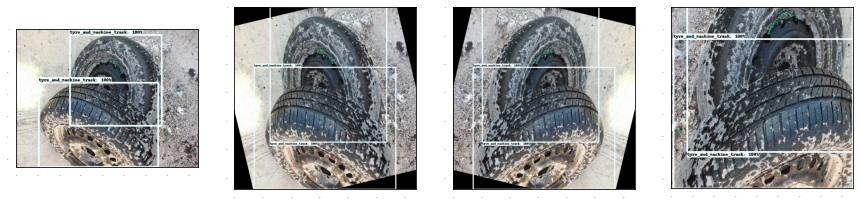

In [46]:
plt.rcParams['figure.figsize'] = [15, 10]

idx = 0

plt.subplot(1, 4, 1)
plot_detections(
      cv2.resize(x_train_np[idx], dsize=(421, 320), interpolation=cv2.INTER_CUBIC).astype('int'),
      y_train_boxes[idx],
      y_train_classes[idx],
      np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
      category_index)

# alpha = -math.pi/4

rotated_image, rotated_box = random_rotate(x_train_np[idx], y_train_boxes[idx], 1)

plt.subplot(1, 4, 2)
plot_detections(
      rotated_image,
      rotated_box,
      y_train_classes[idx],
      np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
      category_index)

flipped_image, flipped_box = random_horizontal_flip(rotated_image, rotated_box, 1)

plt.subplot(1, 4, 3)

plot_detections(
      flipped_image,
      flipped_box,
      y_train_classes[idx],
      np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
      category_index)

cropped_image, cropped_boxes, cropped_classes = random_crop(flipped_image, flipped_box, y_train_classes[idx], 1)

plt.subplot(1, 4, 4)
plot_detections(
      cropped_image,
      cropped_boxes,
      cropped_classes,
      np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
      category_index)

### mAP Block

In [47]:
# Calculate IOU 
  # There is one IOU value per box (in prediction)
  # Match to Ground truth or none

# Ground truth boxes: m x 4 np array 
# Detection boxes: 1 x 100 x 4 tensor 

# [ymin, xmin, ymax, xmax]

# xi1 = maximum of the x1 coordinates of the two boxes
# yi1 = maximum of the y1 coordinates of the two boxes
# xi2 = minimum of the x2 coordinates of the two boxes
# yi2 = minimum of the y2 coordinates of the two boxes

def iou(box1, box2):
  """Implement the intersection over union (IoU) between box1 and box2
    
  Arguments:
  box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
  """

  # Assign variable names to coordinates for clarity
  (box1_y1, box1_x1, box1_y2, box1_x2) = box1
  (box2_y1, box2_x1, box2_y2, box2_x2) = box2
  
  # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2
  xi1 = np.maximum(box1_x1, box2_x1)
  yi1 = np.maximum(box1_y1, box2_y1)
  xi2 = np.minimum(box1_x2, box2_x2)
  yi2 = np.minimum(box1_y2, box2_y2)
  inter_width = yi2 - yi1
  inter_height = xi2 - xi1
  if inter_width < 0 or inter_height < 0:
      return 0
  inter_area = inter_width * inter_height

  # Calculate the Union area
  box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
  box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
  union_area = (box1_area + box2_area) - inter_area
  
  # compute the IoU
  iou = inter_area / union_area
  
  return iou

def filter_from_score(scores, classes, boxes, threshold):
  for i, score in enumerate(scores):
    if score < threshold:
      break
  return scores[:i], classes[:i], boxes[:i]

def get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes):

  '''
    Arguments:
    detected_boxes: (m x 4) for each image
    detected_classes: (m x 1) for each image

    gt_boxes: (n x 4)
    gt_classes: (n x 1)
  
    Output:
    iou_arr: (m x 4), maximum iou for each detection
    detected_which: (m x 4) index to detection
  '''

  ious_arr = [0] * len(detected_boxes)
  detected_which = [-1] * len(detected_boxes)
  hash_table = [None] * len(gt_boxes)

  # edge case: no detections or no ground truth boxes
  if len(detected_boxes) == 0:
    return [], []

  if len(gt_boxes) == 0:
    # print(f'no objects, {len(detected_boxes)} detections all wrong')
    return [0] * len(detected_boxes), [-1] * len(detected_boxes)

  for idx_detection, (box, label) in enumerate(zip(detected_boxes, detected_classes)):
    max_iou = 0
    # assume no detection
    for idx_gt, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
      if gt_class == label:
        iou_val = iou(gt_box, box)
        if iou_val > max_iou:
          max_iou = iou_val
          detected_which[idx_detection] = idx_gt
    
    detected_gt = detected_which[idx_detection]
    if not hash_table[detected_gt]:
      # print(detected_gt)
      hash_table[detected_gt] = (max_iou, idx_detection)
    else:
      # compare iou, if larger than existing assigned value for a gt box:
      if hash_table[detected_gt][0] < max_iou:
        # change detected_gt for the box currently assigned in the slot
        # print(f'need to delete {hash_table[detected_gt][1]}, which is currently {detected_which[hash_table[detected_gt][1]]}, replacing with {idx_detection}')
        detected_which[hash_table[detected_gt][1]] = -1
        # print(f'now it should be {detected_which[hash_table[detected_gt][1]]}')
        # change hash table value
        hash_table[detected_gt] = (max_iou, idx_detection)
      elif hash_table[detected_gt][0] > max_iou:
        # this detection is worse than previous ones, hence a false positive
        detected_which[idx_detection] = -1       
    ious_arr[idx_detection] = max_iou

  # print(f'{len(detected_boxes)} detections')
  # print(f'detected_which: {detected_which}')
  # print(f'hash table: {hash_table}')
  return ious_arr, detected_which

def get_tpfp(ious_arr, detected_which, iou_threshold = 0.5):
  tpfp = []
  for which, iou_val in zip(detected_which, ious_arr):
    if which < 0 or iou_val < iou_threshold:
      tpfp.append(0)
    else:
      tpfp.append(1) 
  
  return tpfp

def get_tpfp_list(detected_box_list, detected_class_list, detected_score_list, gt_box_list, gt_class_list, iou_threshold):
  '''
    Categorizes detections into a list of true positives and false positives in descending order of confidence level
  '''
  tpfp_list = []

  for idx in range(len(detected_score_list)):
    detected_boxes, detected_classes, detected_scores = detected_box_list[idx], detected_class_list[idx], detected_score_list[idx]

    gt_boxes = gt_box_list[idx]
    gt_classes = gt_class_list[idx]

    ious_arr, detected_which = get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes)

    tpfp = get_tpfp(ious_arr, detected_which, iou_threshold=iou_threshold)

    tpfp_score_pairs = [(i, j) for i, j in zip(tpfp, detected_scores)]

    tpfp_list += tpfp_score_pairs
  
  # print(f'tpfp_list: {tpfp_list}')
  return tpfp_list

def calculate_map(detected_box_list, 
                  detected_class_list, 
                  detected_score_list, 
                  gt_box_list, 
                  gt_class_list, 
                  num_of_classes,
                  iou_threshold = 0.5, 
                  suppress_output = True):
  '''
    calculates mAP, outputs precision and recall

    Inputs are filtered lists of detection boxes, classes, and confidence scores
    Detections have to be preprocessed and filtered based on confidence threshold

    detected_box_list: m x ? x 4
    detected_class_list: m x ?
    detected_score_list: m x ?

    gt_box_list: m x ?
    gt_class_list: m x ?

    where m is the number of samples
    ? because the number of detections and number of gt boxes is different for each sample
    all lists are lists of np arrays
  '''

  precision_list = []
  recall_list = []
  map_list = []

  for c in range(num_of_classes):

    class_eval = c + 1
    length = len(detected_box_list)
    detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    detected_classes_eval = [np.array([])]*length
    detected_scores_eval = [np.array([])]*length

    length = len(gt_class_list)
    gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    gt_classes_eval = [np.array([])]*length


    for i, detected_class in enumerate(detected_class_list):
      for j, Class in enumerate(detected_class):
        if Class == class_eval:
          detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_class_list[i][j])
          detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_box_list[i][j]])
          detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_score_list[i][j])
      if detected_boxes_eval[i].shape[0] == 1:
        detected_boxes_eval[i] = np.array([])
      else:
        detected_boxes_eval[i] = detected_boxes_eval[i][1:]

    for i, gt_class in enumerate(gt_class_list):
      for j, Class in enumerate(gt_class):
        if Class == class_eval:
          gt_classes_eval[i] = np.append(gt_classes_eval[i], gt_class_list[i][j])
          gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], gt_box_list[i][j]])
      if gt_boxes_eval[i].shape[0] == 1:
        gt_boxes_eval[i] = np.array([])
      else:
        gt_boxes_eval[i] = gt_boxes_eval[i][1:]

    tpfp_list = get_tpfp_list(detected_boxes_eval, 
                              detected_classes_eval, 
                              detected_scores_eval, 
                              gt_boxes_eval, 
                              gt_classes_eval, 
                              iou_threshold=iou_threshold)
                              

    tpfp_list.sort(key=lambda tup: tup[1], reverse=True)
    # print(f'sorted tpfp: {tpfp_list}')

    precisions = []
    recalls = []
    tp = 0
    fp = 0

    total = 0
    for i in gt_boxes_eval:
      total += len(i)

    detection_total = 0
    for i in detected_boxes_eval:
      detection_total += len(i)

    for i, (tpfp, _) in enumerate(tpfp_list):
      if tpfp == 1:
        tp += 1
      else:
        fp += 1

      precision = tp/(tp+fp)
      if total > 0:
        recall = tp/total
      else:
        recall = 0

      precisions.append(precision)
      recalls.append(recall)
      
    if not suppress_output:
      print(f'{selected_classes[c+1]}: {total} annotations')
      print(f'{tp} / {detection_total} correct detections \n')
  
    map = np.trapz(precisions, recalls)
    precision_list.append(np.array(precisions))
    recall_list.append(np.array(recalls))
    map_list.append(map)

  return precision_list, recall_list, map_list

## Training


### train()

In [50]:
def train(epochs, 
          batch_size, 
          train_step_fn, 
          options):
  '''
    Performs training given epoch and batch size 

    Note: this function does not generalize, it's just a wrapper, neither 
    x_train_np or training labels are passed as arguments
  '''
  flip_prob = options['flip_prob']
  rotate_prob = options['rotate_prob']
  hue_prob = options['hue_prob']
  crop_prob = options['crop_prob']

  tf.keras.backend.clear_session()

  num_batches = math.ceil(len(x_train_np)/ batch_size)

  print('Started fine-tuning!', flush=True)

  cv_loss, cv_map = val_evaluate()

  print(f'Initial cv_loss: {cv_loss:.6f}, cv_map: {cv_map:.6f}', flush=True)

  for e in range(epochs):

    epoch_loss = 0

    all_keys = list(range(len(x_train_np)))
    random.shuffle(all_keys)

    for i in tqdm(range(num_batches)):

      image_list, boxes_list, classes_list = [], [], []

      # Grab keys for a random subset of examples
      example_keys = all_keys[(i*batch_size):((i+1)*batch_size)]

      for key in example_keys:
        temp_image = x_train_np[key]
        temp_box = y_train_boxes[key]
        temp_class = y_train_classes[key]
        
        # Augmentation:
        # All of these are done on numpy arrays because tensors are incompatible with rotation 
        temp_image, temp_box = random_horizontal_flip(temp_image, temp_box, flip_prob)
        temp_image, temp_box = random_rotate(temp_image, temp_box, rotate_prob)
        temp_image, temp_box = random_hue(temp_image, temp_box, hue_prob)
        temp_image, temp_box, temp_class = random_crop(temp_image, temp_box, temp_class, crop_prob)

        image_list.append(temp_image)
        boxes_list.append(temp_box)
        classes_list.append(temp_class)

      # convert to tensors
      image_tensors, boxes_tensors, classes_tensors = np_to_tensors(image_list, boxes_list, classes_list)

      # Training step (forward pass + backwards pass)
      total_loss = train_step_fn(image_tensors, boxes_tensors, classes_tensors)

      epoch_loss += total_loss.numpy()

    epoch_loss /= num_batches

    cv_loss, cv_map = val_evaluate()
    print('epoch {} of {}, loss= {:.6}, cv_loss = {:.6}, cv_map = {:.6}'.format(e+1, epochs, epoch_loss, cv_loss, cv_map), flush=True)

  print(f'final cv_loss: {cv_loss :.6}, cv_map: {cv_map :.6}')
  print('Done fine-tuning!')

In [51]:
detection_model.build(input_shape=(1, 640, 640, 3))

### Top - Hyperparameter

In [52]:
# SELECT THE TOP LAYERS, and set up the training
tf.keras.backend.clear_session()

# Hyper parameters
epochs = 10
batch_size = 1

# Define Optimizer
optimizer = tf.keras.optimizers.Adam()

options = {
  'flip_prob'   : 0.5,
  'rotate_prob' : 0.2,
  'hue_prob'    : 0.5,
  'crop_prob'   : 0.2
}

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['mask_rcnn_keras_box_predictor'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune, training=True)

# Run on CV:
val_loss, map = val_evaluate()
print(f'validation loss: {val_loss :.6}, map: {map :.6}') # validation loss: 1.98529, map: 0.00635156

# 1.9877

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

validation loss: 1.79153, map: 0.0075517


### Top - Train

In [53]:
train(epochs, batch_size, train_step_fn, options)

Started fine-tuning!


KeyboardInterrupt: ignored

In [ ]:
from tqdm import tqdm
train(epochs, batch_size, train_step_fn, options)

### All - Hyperparameter

In [ ]:
# SELECT THE TOP LAYERS, and set up the training
tf.keras.backend.clear_session()

# Hyper parameters
epochs = 5
batch_size = 1

# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6)

options = {
  'flip_prob'   : 0,
  'rotate_prob' : 0,
  'hue_prob'    : 0,
  'crop_prob'   : 0
}

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['conv', 'mask_rcnn_keras_box_predictor'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune, training=True)

# Run on CV:
val_loss, map = val_evaluate()
print(f'validation loss: {val_loss :.6}, map: {map :.6}')

### All - Train

In [ ]:
train(epochs, batch_size, train_step_fn, options)

## Evaluate

In [ ]:
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  detection_model._is_training = False
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

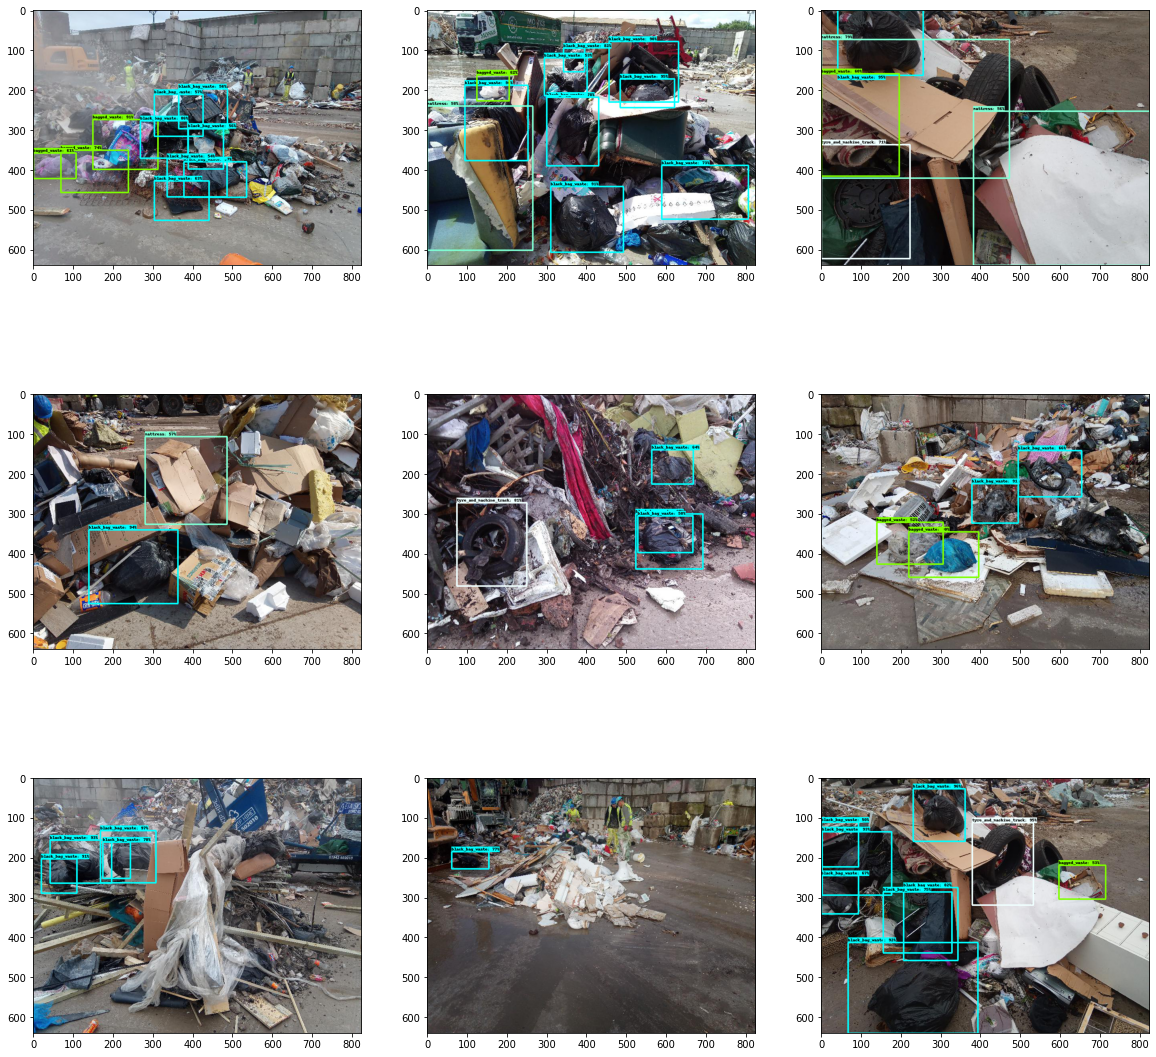

In [ ]:
plt.figure(figsize=(20,20))
for i in range(9):
  offset = 6
  input_tensor = tf.convert_to_tensor(np.expand_dims(x_test_np[i+offset], axis=0), dtype=tf.float32)
  detection = detect(input_tensor)
  plt.subplot(3, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+offset], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.5)
plt.show()

In [ ]:
input_tensor = tf.convert_to_tensor(np.expand_dims(x_test_np[0], axis=0), dtype=tf.float32)

detection = detect(input_tensor)

In [ ]:
idx = 4

4


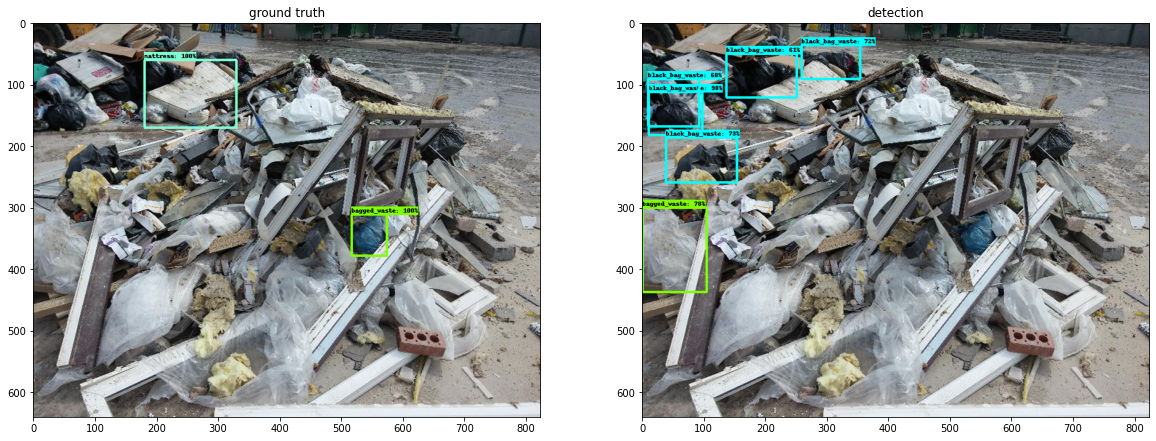

In [ ]:
plt.figure(figsize=(20, 10))
detection = detect(test_image_tensors[idx])

plt.subplot(1, 2, 1)

plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes[idx],
      y_test_classes[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)
plt.title('ground truth')

plt.subplot(1, 2, 2)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.6)
plt.title('detection')

print(idx)
idx += 1

### mAP - Train

In [ ]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in tqdm(range(len(y_train_classes))):
  detection = detect(train_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.8)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)




  0%|          | 0/538 [00:00<?, ?it/s]

  0%|          | 1/538 [00:00<03:11,  2.80it/s]

  0%|          | 2/538 [00:00<03:11,  2.79it/s]

  1%|          | 3/538 [00:01<03:05,  2.88it/s]

  1%|          | 4/538 [00:01<03:11,  2.79it/s]

  1%|          | 5/538 [00:01<03:04,  2.90it/s]

  1%|          | 6/538 [00:02<02:55,  3.03it/s]

  1%|▏         | 7/538 [00:02<03:04,  2.88it/s]

  1%|▏         | 8/538 [00:02<03:00,  2.93it/s]

  2%|▏         | 9/538 [00:03<02:53,  3.05it/s]

  2%|▏         | 10/538 [00:03<02:49,  3.12it/s]

  2%|▏         | 11/538 [00:03<02:43,  3.23it/s]

  2%|▏         | 12/538 [00:03<02:51,  3.07it/s]

  2%|▏         | 13/538 [00:04<02:47,  3.14it/s]

  3%|▎         | 14/538 [00:04<02:51,  3.06it/s]

  3%|▎         | 15/538 [00:04<02:47,  3.13it/s]

  3%|▎         | 16/538 [00:05<02:40,  3.25it/s]

  3%|▎         | 17/538 [00:05<02:48,  3.09it/s]

  3%|▎         | 18/538 [00:05<02:43,  3.18it/s]

  4%|▎         | 19/538 [00:06<02:52,  3.01it/s]

  4%|▎         |

In [ ]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_train_boxes, 
                          y_train_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.2,
                          suppress_output = False)

print(map)

print(sum(map)/num_classes)



bagged_waste: 765 annotations
186 / 250 correct detections 

black_bag_waste: 1282 annotations
476 / 563 correct detections 

mattress: 140 annotations
78 / 108 correct detections 

tyre_and_machine_track: 246 annotations
117 / 160 correct detections 

[0.2054394194382732, 0.348918578641804, 0.46638160059331335, 0.33801040076080047]
0.3396874998585478


### mAP - Val

In [ ]:
val_detected_boxes = []
val_detected_classes = []
val_detected_scores = []

for i in tqdm(range(len(x_val_np))):
  detection = detect(val_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.1)
  val_detected_boxes.append(detected_box)
  val_detected_classes.append(detected_class)
  val_detected_scores.append(detected_score)

100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


In [ ]:
p, r, map = calculate_map(val_detected_boxes, 
                          val_detected_classes, 
                          val_detected_scores, 
                          y_val_boxes, 
                          y_val_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5, 
                          suppress_output = False)

print(map)
print(f'mAP: {sum(map)/num_classes}')

### mAP - Test

In [ ]:
test_detected_boxes = []
test_detected_classes = []
test_detected_scores = []

for i in tqdm(range(len(x_test_np))):
  detection = detect(test_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.6)
  test_detected_boxes.append(detected_box)
  test_detected_classes.append(detected_class)
  test_detected_scores.append(detected_score)



  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:06,  2.59it/s]

 11%|█         | 2/18 [00:00<00:05,  2.69it/s]

 17%|█▋        | 3/18 [00:01<00:05,  2.88it/s]

 22%|██▏       | 4/18 [00:01<00:04,  2.92it/s]

 28%|██▊       | 5/18 [00:01<00:04,  3.03it/s]

 33%|███▎      | 6/18 [00:01<00:03,  3.05it/s]

 39%|███▉      | 7/18 [00:02<00:03,  3.20it/s]

 44%|████▍     | 8/18 [00:02<00:03,  3.15it/s]

 50%|█████     | 9/18 [00:02<00:02,  3.07it/s]

 56%|█████▌    | 10/18 [00:03<00:02,  3.13it/s]

 61%|██████    | 11/18 [00:03<00:02,  3.11it/s]

 67%|██████▋   | 12/18 [00:03<00:01,  3.19it/s]

 72%|███████▏  | 13/18 [00:04<00:01,  3.22it/s]

 78%|███████▊  | 14/18 [00:04<00:01,  3.28it/s]

 83%|████████▎ | 15/18 [00:04<00:00,  3.09it/s]

 89%|████████▉ | 16/18 [00:05<00:00,  3.14it/s]

 94%|█████████▍| 17/18 [00:05<00:00,  3.12it/s]

100%|██████████| 18/18 [00:05<00:00,  3.13it/s]


In [ ]:
p, r, map = calculate_map(test_detected_boxes, 
                          test_detected_classes, 
                          test_detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.2, 
                          suppress_output = False)

print(map)
print(f'mAP: {sum(map)/num_classes}')

bagged_waste: 22 annotations
7 / 14 correct detections 

black_bag_waste: 78 annotations
43 / 67 correct detections 

mattress: 4 annotations
0 / 2 correct detections 

tyre_and_machine_track: 7 annotations
2 / 3 correct detections 

[0.18536595979777798, 0.41142219442624206, 0.0, 0.14285714285714285]
mAP: 0.18491132427029072
